# Google Cloud Vision APIクイックツアー

このノートブックは、下記のチュートリアルの内容を噛み砕いて解説したものです。

* [Label Detection Tutorial](https://cloud.google.com/vision/docs/label-tutorial)
* [Face Detection Tutorial](https://cloud.google.com/vision/docs/face-tutorial)

[Google Cloud Vision API](https://cloud.google.com/vision)を利用するために、事前に[GCP](https://cloud.google.com/) (Google Cloud Platform) のユーザー登録をしておいてください。（このノートブックの内容は、60日間の$300無償利用枠で試すことが可能です。）

## 事前準備

GCPの[API Manager](https://console.developers.google.com/apis/library)で、Cloud Vision APIを有効化した後、「認証情報」のメニューからサービスアカウント「Compute Engine default service account」のアカウントキーをJSON形式でダウンロードします。ダウンロードしたファイル（ここでは、ファイル名を「Vision API Project-5912afb0bd62.json」とします）は、Jupyterのファイルメニュー画面でアップロードしておきます。

ライブラリーモジュールをインポートします。

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import base64
import httplib2
import os

from PIL import Image
from PIL import ImageDraw

from googleapiclient import discovery
from oauth2client.client import GoogleCredentials

先ほどアップロードしたアカウントキーファイルを利用して、APIサービスのハンドラーオブジェクトを取得します。

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'Vision API Project-5912afb0bd62.json'
DISCOVERY_URL='https://{api}.googleapis.com/$discovery/rest?version={apiVersion}'
credentials = GoogleCredentials.get_application_default()
service = discovery.build('vision', 'v1', credentials=credentials,
                          discoveryServiceUrl=DISCOVERY_URL)

分析に使用する画像ファイルをWebからダウンロードします。

ここでは、一般のWebページで公開されている画像を直接ダウンロードしています。

画像の引用元はこちらです。http://www.lawson.co.jp/campaign/akb/

In [3]:
!curl http://www.lawson.co.jp/campaign/akb/img/mv.png > sample01.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  417k  100  417k    0     0  2302k      0 --:--:-- --:--:-- --:--:-- 2306k


ダウンロードした画像を確認します。

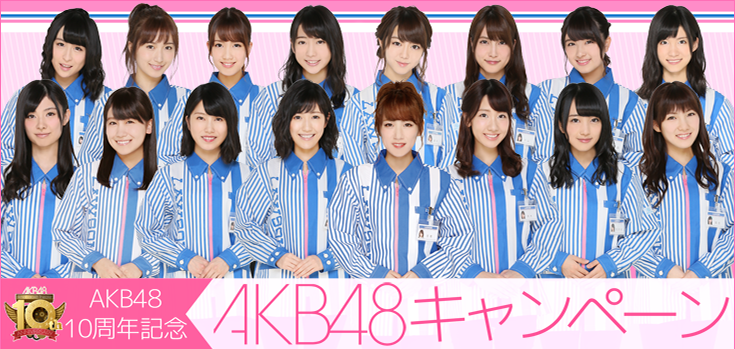

In [4]:
Image.open("sample01.png")

## 画像のラベリング

画像の内容を判別してラベルを取得する関数を用意します。

In [5]:
def get_labels(photo_file):
    with open(photo_file, 'rb') as image:
        image_content = base64.b64encode(image.read())
        service_request = service.images().annotate(body={
            'requests': [{
                'image': {
                    'content': image_content.decode('UTF-8')
                },
                'features': [{
                    'type': 'LABEL_DETECTION',
                    'maxResults': 5
                }]
            }]
        })
        response = service_request.execute()
        return response['responses'][0]['labelAnnotations']

先ほどアップロードした画像のラベルを取得します。ラベルの候補と確信度（%）を最大5つ表示します。

In [6]:
labels = get_labels('sample01.png')
for label in labels:
    print ('%s : %2d%%' % (label['description'], label['score']*100))

person : 94%
team : 80%
class : 78%
profession : 72%


チーム（team）を組んだ人物（person）の画像であると認識しています。学級写真（class）は人の配置、専門職（profession）は服装から判断しているのかも知れません。

## 顔認識サンプル

顔認識情報を取得する関数を用意します。

In [7]:
def get_faces(photo_file):
    with open(photo_file, 'rb') as image:
        image_content = base64.b64encode(image.read())
        service_request = service.images().annotate(body={
            'requests': [{
                'image': {
                    'content':  image_content.decode('UTF-8')
                },
                'features': [{
                    'type': 'FACE_DETECTION',
                    'maxResults': 100
                }]
            }]
        })
        response = service_request.execute()
        return response['responses'][0]['faceAnnotations']

さらに、取得した情報を用いて、顔の部分に枠を描く関数を用意します。joyLikelihood（笑顔）がVERY_LIKELY（非常に確からしい）ものについては、ピンク、その他は、グリーンの枠を描きます。

In [8]:
def highlight_faces(photo_file, responce):
    im = Image.open(photo_file)
    draw = ImageDraw.Draw(im)
    for face in faces:
        if face['joyLikelihood'] == 'VERY_LIKELY':
            color = '#ff8888'
        else:
            color = '#00ff00'
        box = [(v.get('x', 0.0), v.get('y', 0.0)) for v in face['fdBoundingPoly']['vertices']]
        draw.line(box + [box[0]], width=5, fill=color)
    return im

サンプル画像で試してみます。

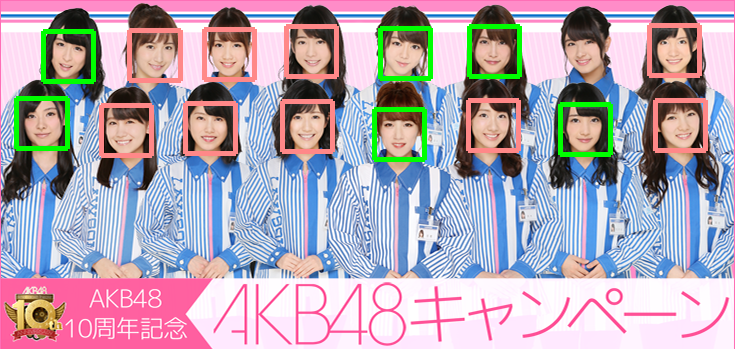

In [9]:
faces = get_faces('sample01.png')
highlight_faces('sample01.png', faces)

歯が見えていると笑顔だと認識されやすいようです。一人だけ認識に失敗していますが、この部分だけを切り出した場合なども調べると面白いかもしれません。